In [50]:
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# Setting up the DataFrame to do EDA

In [203]:
# Setting it all up 
# Load necessary pickles
df = pd.read_pickle('df_1950to2019_stats.pickle')

draft_df = pd.read_pickle('draft_history_df.pickle')

# Merge the two dataframes to have all data in single df
merged_df = df.merge(draft_df[['pid','year','from','to','pk']],on='pid',how='left')

# getting rid of players missing draft year
merged_df = merged_df[merged_df.year.isna()==False]
# cleaning up the player names
merged_df.player = [player.strip('*') for player in merged_df.player]

Decided to use only data starting from the year that the NBA introduced the 3-point line

In [ ]:
# Creating the cleaned up dataframe 
# Filter out players where 3-point field goals (3p) was NaN
    # NaN indicated pre-3-point-era
df_3p_era = merged_df[merged_df['3p'].isna()==False]

# replace NaN in 3pt percentage with 0 in order to convert column dtype to numerical
    # 3pt percentage being NaN meant these players did not shoot any 3-pointers at all
    # for the entire season
df_3p_era['3p_pct'] = df_3p_era['3p_pct'].fillna(0)

# changing all string formatted numerical data into numerical format
for col in df_3p_era.columns:
    try:
        df_3p_era[col] = pd.to_numeric(df_3p_era[col])
    except:
        pass

# creating experience feature (how long the player was in the NBA at the point in time the stats were recorded)
df_3p_era['experience'] = df_3p_era.season - df_3p_era['from']

# calculating how many fantasy points each player would've scored for the season
# using Yahoo's fantasy basketball scoring system
df_3p_era['ftsy_pts']=(df_3p_era.pts*1)+(df_3p_era.trb*1.2)+(df_3p_era.ast*1.5)+(df_3p_era.blk*3)+(df_3p_era.stl*3)-(df_3p_era.tov)

In [62]:
df_3p_era.to_pickle('final_df.pickle')

# Some EDA

In [129]:
df_3p_era = pd.read_pickle('final_df.pickle')

dupes = df_3p_era[df_3p_era.duplicated(['pid','age'],keep=False)].sort_values(by=['player','g'],ascending=False)

data = df_3p_era.drop(dupes.index)

data = pd.concat([data, dupes[dupes.tm == 'TOT']])

In [148]:
# Player position distribution 
pos_count = df_3p_era[df_3p_era.tm != 'TOT'].groupby('pos').count()[['player']].reset_index()
fig = go.Figure(data=go.Pie(labels=pos_count.pos,values=pos_count.player))
fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=0.5)))

fig_bar = go.Figure(data=go.Bar(x=pos_count.pos,y=pos_count.player))

# fig.show()
fig_bar.show()

In [149]:
# Display trend of positions over the years 
pos_season_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season','pos']).count()[['player']].unstack()

names = list(set(pos_season_df.player.columns))

# create a container for each go.Bar instance
lines = []

# loop through the names list which is each player class 
for i in range(len(names)):
    # dictionary with necessary arguments to graph
    line_dict = dict(name=names[i], x=pos_season_df.index, y=pos_season_df.player[names[i]])
    # add to bars container
    lines.append(line_dict)

# set fig1 to the Figure instance
fig_trend = go.Figure(lines)

fig_trend.update_layout(
    title=go.layout.Title(
        text="Position Trend",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Position Count",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

fig_trend.show()

In [150]:
# Display trend of stats over the years 
scoring_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season']).sum()[['g','pts','trb','ast','stl','blk','tov','ws']]

value_names = list(scoring_df.columns)

# create a container for each go.Bar instance
lines = []

# loop through the names list which is each player class 
for i in range(len(value_names)):
    # dictionary with necessary arguments to graph
    line_dict = dict(name=value_names[i], x=scoring_df.index, y=scoring_df[value_names[i]])
    # add to bars container
    lines.append(line_dict)

# set fig1 to the Figure instance
stats_trend = go.Figure(lines)

stats_trend.update_layout(
    title=go.layout.Title(
        text="Stats Trend",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Stats Totals",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

stats_trend.show()

In [138]:
# Display win share vs minutes played 
mp_ws = data.groupby(['player','season']).sum().reset_index()

mp_vs_ws_fig = px.scatter(mp_ws, x='mp', y='ws', color='experience')

mp_vs_ws_fig.update_layout(
    title=go.layout.Title(
        text="Minutes Played VS Win Share",
        xref="paper",
        x=0.5,
        y=0.95,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Minutes Played",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Win Share",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

mp_vs_ws_fig.show()

In [68]:
# Players occupying top 50 win-share spots 

# Michael Jordan is GOAT 

top_50_ws = df_3p_era.sort_values(by='ws',ascending=False).head(50).groupby('player').count()[['ws']].sort_values(by='ws',ascending=False)
top_50_ws = top_50_ws.reset_index()

df_3p_era.sort_values(by='ws',ascending=False).head(50)[['player','pos','age','tm','season','ws','ftsy_pts']]

player pos  age   tm  season    ws  ftsy_pts
9151     Michael Jordan  SG   24  CHI    1988  21.2    5052.3
12817    Michael Jordan  SG   32  CHI    1996  20.4    4139.6
10497    Michael Jordan  SG   27  CHI    1991  20.3    4565.9
19894      LeBron James  SF   24  CLE    2009  20.3    4369.1
12021    David Robinson   C   28  SAS    1994  20.0    4939.5
9580     Michael Jordan  SG   25  CHI    1989  19.8    4997.4
22212      LeBron James  PF   28  MIA    2013  19.3    3956.5
22716      Kevin Durant  SF   25  OKC    2014  19.2    4179.1
10031    Michael Jordan  SG   26  CHI    1990  19.0    4805.5
22106      Kevin Durant  SF   24  OKC    2013  18.9    3992.0
15095  Shaquille O'Neal   C   27  LAL    2000  18.6    4688.1
20489      LeBron James  SF   25  CLE    2010  18.5    4244.3
20035        Chris Paul  PG   23  NOH    2009  18.3    4037.9
16962     Kevin Garnett  PF   27  MIN    2004  18.3    4649.3
12986    David Robinson   C   30  SAS    1996  18.3    4577.5
13384    Michael Jordan  SG   33  CHI    1997  18.3    3923.4
23909     Stephen Curry  PG   27  GSW    2016  17.9    3971.5
15932        Tim Duncan  PF   25  SAS    2002  17.8    4328.9
19448        Chris Paul  PG   22  NOH    2008  17.8    3918.7
10952    Michael Jordan  SG   28  CHI    1992  17.7    4321.7
18314     Dirk Nowitzki  PF   27  DAL    2006  17.7    3630.6
12472    David Robinson   C   29  SAS    1995  17.5    4599.4
9846    Charles Barkley  SF   26  PHI    1990  17.3    3891.3
11393    Michael Jordan  SG   29  CHI    1993  17.2    4448.4
10621    David Robinson   C   25  SAS    1991  17.0    4759.6
8750     Michael Jordan  SG   23  CHI    1987  16.9    4933.5
11975  Shaquille O'Neal   C   21  ORL    1994  16.9    4654.9
13431       Karl Malone  PF   33  UTA    1997  16.7    4021.8
8979    Charles Barkley  PF   24  PHI    1988  16.7    4091.2
16417        Tim Duncan  PF   26  SAS    2003  16.5    4237.6
10019     Magic Johnson  PG   30  LAL    1990  16.5    3960.9
23391      James Harden  SG   25  HOU    2015  16.4    3936.3
13978       Karl Malone  PF   34  UTA    1998  16.4    3915.8
18854     Dirk Nowitzki  PF   28  DAL    2007  16.3    3317.1
18204      LeBron James  SF   21  CLE    2006  16.3    4233.7
17553     Kevin Garnett  PF   28  MIN    2005  16.1    4322.6
16610     Dirk Nowitzki  PF   24  DAL    2003  16.1    3745.7
9412    Charles Barkley  PF   25  PHI    1989  16.1    4032.7
9566      Magic Johnson  PG   29  LAL    1989  16.1    4108.4
16574     Tracy McGrady  SG   23  ORL    2003  16.1    3963.1
20353      Kevin Durant  SF   21  OKC    2010  16.1    3883.1
23589        Chris Paul  PG   29  LAC    2015  16.1    3595.2
10079       Karl Malone  PF   26  UTA    1990  15.9    4181.2
22826      LeBron James  PF   29  MIA    2014  15.9    3631.6
8740      Magic Johnson  PG   27  LAL    1987  15.9    4201.3
13943    Michael Jordan  SG   34  CHI    1998  15.8    3724.5
8218         Larry Bird  SF   29  BOS    1986  15.8    4301.5
11482   Hakeem Olajuwon   C   30  HOU    1993  15.8    5072.1
7851         Larry Bird  SF   28  BOS    1985  15.7    4534.9
23277     Stephen Curry  PG   26  GSW    2015  15.7    3525.7

In [69]:
# How many times does a player name appear in the top 50 win shares list?
fig10 = go.Figure(data=go.Pie(labels=top_50_ws.player,values=top_50_ws.ws))
fig10.show()

In [70]:
# Players occupying top-50 fantasy points spots 
top_50_ftsy = df_3p_era.sort_values(by='ftsy_pts',ascending=False).head(50).groupby('player').count()[['ftsy_pts']].sort_values(by='ftsy_pts',ascending=False).reset_index()
df_3p_era.sort_values(by='ftsy_pts',ascending=False).head(50)[['player','pos','age','tm','season','ws','ftsy_pts']]

player pos  age   tm  season    ws  ftsy_pts
11482      Hakeem Olajuwon   C   30  HOU    1993  15.8    5072.1
10124      Hakeem Olajuwon   C   27  HOU    1990  11.2    5058.8
9151        Michael Jordan  SG   24  CHI    1988  21.2    5052.3
9580        Michael Jordan  SG   25  CHI    1989  19.8    4997.4
12021       David Robinson   C   28  SAS    1994  20.0    4939.5
8750        Michael Jordan  SG   23  CHI    1987  16.9    4933.5
24929    Russell Westbrook  PG   28  OKC    2017  13.1    4905.8
10031       Michael Jordan  SG   26  CHI    1990  19.0    4805.5
9665       Hakeem Olajuwon   C   26  HOU    1989  12.4    4793.5
11978      Hakeem Olajuwon   C   31  HOU    1994  14.3    4764.5
10621       David Robinson   C   25  SAS    1991  17.0    4759.6
15095     Shaquille O'Neal   C   27  LAL    2000  18.6    4688.1
11975     Shaquille O'Neal   C   21  ORL    1994  16.9    4654.9
16962        Kevin Garnett  PF   27  MIN    2004  18.3    4649.3
9946         Patrick Ewing   C   27  NYK    1990  13.5    4628.6
12472       David Robinson   C   29  SAS    1995  17.5    4599.4
25897         James Harden  PG   29  HOU    2019  15.2    4579.6
12986       David Robinson   C   30  SAS    1996  18.3    4577.5
10497       Michael Jordan  SG   27  CHI    1991  20.3    4565.9
7851            Larry Bird  SF   28  BOS    1985  15.7    4534.9
10166       David Robinson   C   24  SAS    1990  15.1    4532.6
24581         James Harden  PG   27  HOU    2017  15.0    4520.3
11393       Michael Jordan  SG   29  CHI    1993  17.2    4448.4
11532       David Robinson   C   27  SAS    1993  13.2    4446.7
16439        Kevin Garnett  PF   26  MIN    2003  15.6    4444.9
5991   Kareem Abdul-Jabbar   C   32  LAL    1980  14.8    4439.7
25269         LeBron James  PF   33  CLE    2018  14.0    4436.3
19894         LeBron James  SF   24  CLE    2009  20.3    4369.1
25591    Russell Westbrook  PG   29  OKC    2018  10.1    4342.8
10417        Patrick Ewing   C   28  NYK    1991  10.0    4329.0
15932           Tim Duncan  PF   25  SAS    2002  17.8    4328.9
17553        Kevin Garnett  PF   28  MIN    2005  16.1    4322.6
10952       Michael Jordan  SG   28  CHI    1992  17.7    4321.7
16358          Kobe Bryant  SG   24  LAL    2003  14.9    4315.3
20160          Dwyane Wade  SG   27  MIA    2009  14.7    4312.1
12426     Shaquille O'Neal   C   22  ORL    1995  14.0    4308.2
8218            Larry Bird  SF   29  BOS    1986  15.8    4301.5
20489         LeBron James  SF   25  CLE    2010  18.5    4244.3
16417           Tim Duncan  PF   26  SAS    2003  16.5    4237.6
18204         LeBron James  SF   21  CLE    2006  16.3    4233.7
10536          Karl Malone  PF   27  UTA    1991  15.5    4207.4
12428      Hakeem Olajuwon   C   32  HOU    1995  10.7    4205.5
15619     Shaquille O'Neal   C   28  LAL    2001  14.9    4203.5
11931          Karl Malone  PF   30  UTA    1994  13.4    4202.0
8740         Magic Johnson  PG   27  LAL    1987  15.9    4201.3
11474     Shaquille O'Neal   C   20  ORL    1993  10.4    4198.4
10079          Karl Malone  PF   26  UTA    1990  15.9    4181.2
7995        Michael Jordan  SG   21  CHI    1985  14.0    4179.3
22716         Kevin Durant  SF   25  OKC    2014  19.2    4179.1
8136          Isiah Thomas  PG   23  DET    1985  11.2    4171.7

In [71]:
# How many times does a player show up in the top 50 fantasy points list? 
fig5 = go.Figure(data=go.Pie(labels=top_50_ftsy.player,values=top_50_ftsy.ftsy_pts))
fig5.show()

In [72]:
# Top 50 all-time rookies by win share 
rookies = df_3p_era[df_3p_era.experience==0].groupby(['player'])
rookies_50 = rookies.mean().sort_values(by='ws', ascending=False)[['age','mp','g','ws','per','ftsy_pts','pts','trb',
                                                                   'ast','stl','blk','tov','pf','fg_pct',
                                                                   'ft_pct','3p_pct','year','season']].head(50)
rookies_50

age      mp     g    ws   per  ftsy_pts     pts     trb  \
player                                                                         
David Robinson      24.0  3002.0  82.0  15.1  26.3    4532.6  1993.0   983.0   
Michael Jordan      21.0  3144.0  82.0  14.0  25.8    4179.3  2313.0   534.0   
Tim Duncan          21.0  3204.0  82.0  12.8  22.6    3743.4  1731.0   977.0   
Larry Bird          23.0  2955.0  82.0  11.2  20.5    3647.4  1745.0   852.0   
Magic Johnson       20.0  2795.0  77.0  10.5  20.6    3325.7  1387.0   596.0   
Chris Paul          20.0  2808.0  78.0  10.4  22.1    3014.5  1258.0   400.0   
Shaquille O'Neal    20.0  3071.0  81.0  10.4  22.9    4198.4  1893.0  1122.0   
Hakeem Olajuwon     22.0  2914.0  82.0  10.2  21.1    3750.3  1692.0   974.0   
Blake Griffin       21.0  3112.0  82.0   9.8  21.9    3600.8  1845.0   989.0   
Bill Cartwright     22.0  3150.0  82.0   9.7  17.9    3124.7  1781.0   726.0   
Zydrunas Ilgauskas  22.0  2379.0  82.0   9.4  19.7    2528.1  1139.0   723.0   
Ben Simmons         21.0  2732.0  81.0   9.2  20.0    3413.3  1279.0   659.0   
Larry Johnson       22.0  3047.0  82.0   8.9  18.9    3328.8  1576.0   899.0   
Buck Williams       21.0  2825.0  82.0   8.9  17.2    2903.5  1268.0  1005.0   
Terry Cummings      21.0  2531.0  70.0   8.7  22.8    3187.3  1660.0   744.0   
Yao Ming            22.0  2382.0  82.0   8.7  20.6    2480.5  1104.0   675.0   
Arvydas Sabonis     31.0  1735.0  73.0   8.4  24.7    2230.6  1058.0   588.0   
Brevin Knight       22.0  2483.0  80.0   8.4  17.1    2458.6   723.0   253.0   
Karl-Anthony Towns  20.0  2627.0  82.0   8.3  22.5    3179.1  1503.0   858.0   
Alonzo Mourning     22.0  2644.0  78.0   8.2  20.8    3377.0  1639.0   805.0   
LaPhonso Ellis      22.0  2749.0  82.0   8.0  16.6    2720.3  1205.0   744.0   
Chris Webber        20.0  2438.0  76.0   7.8  21.7    3138.8  1333.0   694.0   
Jeff Ruland         23.0  2214.0  82.0   7.8  18.8    2367.4  1183.0   762.0   
Pau Gasol           21.0  3007.0  82.0   7.6  19.5    3057.5  1441.0   730.0   
Mark Jackson        22.0  3249.0  82.0   7.6  15.7    3266.2  1114.0   396.0   
Kelly Tripucka      22.0  3077.0  82.0   7.5  16.4    2743.6  1772.0   443.0   
Charles Barkley     21.0  2347.0  82.0   7.5  18.3    2540.1  1148.0   703.0   
Elton Brand         20.0  2999.0  81.0   7.5  20.6    3197.5  1627.0   810.0   
Hot Rod Williams    24.0  2714.0  80.0   7.5  16.2    2689.8  1168.0   629.0   
Dwight Howard       19.0  2670.0  82.0   7.3  17.2    2555.1   981.0   823.0   
Andrei Kirilenko    20.0  2151.0  82.0   7.3  18.8    2220.4   880.0   402.0   
Jayson Tatum        19.0  2438.0  80.0   7.1  15.3    2095.4  1112.0   402.0   
Anfernee Hardaway   22.0  3015.0  82.0   7.1  17.4    3086.8  1313.0   439.0   
Kerry Kittles       22.0  3012.0  82.0   6.9  16.0    2552.3  1347.0   319.0   
Joe Smith           20.0  2821.0  82.0   6.8  17.2    2748.9  1251.0   717.0   
Clark Kellogg       21.0  2761.0  81.0   6.8  20.3    3326.5  1625.0   860.0   
Nikola Jokić        20.0  1733.0  80.0   6.7  21.5    2034.5   796.0   560.0   
Andre Iguodala      21.0  2686.0  82.0   6.6  13.5    2085.8   741.0   464.0   
Greg Monroe         20.0  2222.0  80.0   6.6  18.0    1962.7   751.0   601.0   
Luis Scola          27.0  2024.0  82.0   6.5  16.1    1768.0   847.0   525.0   
Dave Greenwood      22.0  2791.0  82.0   6.5  16.2    2891.6  1334.0   773.0   
Steve Francis       22.0  2776.0  77.0   6.4  18.4    2774.3  1388.0   409.0   
Marc Gasol          24.0  2521.0  82.0   6.4  16.7    2210.5   975.0   605.0   
Michael Finley      22.0  3212.0  82.0   6.3  14.0    2330.3  1233.0   374.0   
Chris Bosh          19.0  2510.0  75.0   6.2  15.1    2034.4   861.0   557.0   
Amar'e Stoudemire   20.0  2570.0  82.0   6.2  16.2    2346.2  1106.0   721.0   
Reggie King         22.0  2052.0  82.0   6.2  13.5    1711.2   673.0   566.0   
Wally Szczerbiak    22.0  2171.0  73.0   6.2  15.4    1632.9   845.0   272.0   
Dean Garrett        3

In [61]:
# relationship between win share and fantasy points
ws_fig = px.scatter(df_3p_era[df_3p_era.tm != 'TOT'].groupby('player').mean().reset_index(), x='ws', y='ftsy_pts', color='player')
ws_fig.show()

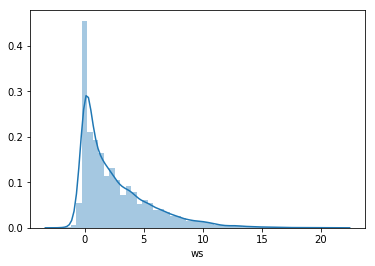

In [73]:
# Win share distribution 
sns.distplot(df_3p_era.ws)

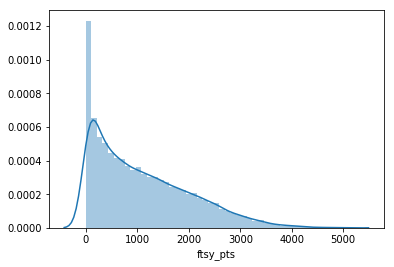

In [74]:
# Fantasy points distribution 
sns.distplot(df_3p_era.ftsy_pts)

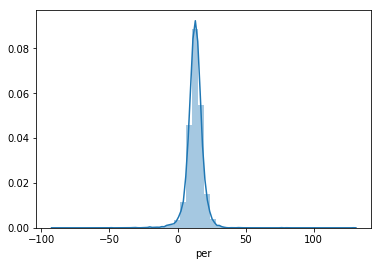

In [75]:
sns.distplot(df_3p_era.per.dropna())

In [76]:
fdf = df_3p_era[df_3p_era.tm !='TOT']

In [77]:
grouped_player_sum = fdf.groupby('player').sum()

In [78]:
above_avg = grouped_player_sum[(grouped_player_sum.ws>grouped_player_sum.ws.mean())&(grouped_player_sum.ftsy_pts>grouped_player_sum.ftsy_pts.mean())]

In [79]:
above_avg.sort_values(by=['ws','ftsy_pts'],ascending=False)

rk  age     g      gs     mp     fg    fga  fg_pct    3p  \
player                                                                          
Karl Malone        4133  589  1476  1471.0  54852  13528  26210   9.745    85   
LeBron James       3552  424  1198  1197.0  46235  11838  23478   8.102  1727   
Michael Jordan     2631  432  1072  1039.0  41011  12192  24537   7.324   581   
John Stockton      6351  589  1504  1300.0  47764   7039  13658   9.737   845   
Dirk Nowitzki      6623  630  1522  1460.0  51368  11169  23734   9.723  1982   
Tim Duncan         2264  570  1392  1389.0  47368  10285  20334   9.584    30   
Kevin Garnett      3183  647  1462  1425.0  50418  10505  21142  10.955   174   
Shaquille O'Neal   5839  586  1207  1197.0  41918  11330  19457  11.743     1   
David Robinson     4454  427   987   985.0  34271   7365  14221   7.182    25   
Charles Barkley     317  456  1073  1012.0  39330   8435  15605   8.524   538   
Reggie Miller      4476  549  1389  1304.0  47619   8241  17499   8.427  2560   
Kobe Bryant        1224  550  1346  1198.0  48637  11719  26200   8.828  1827   
Chris Paul         4815  371   950   950.0  33350   6162  13132   6.542  1268   
Hakeem Olajuwon    4628  549  1238  1186.0  44222  10749  20991   9.120    25   
Magic Johnson      1881  342   906   763.0  33245   6211  11951   6.745   325   
Paul Pierce        6324  570  1343  1285.0  45880   8668  19465   8.390  2143   
Larry Bird          266  377   897   870.0  34443   8591  17334   6.385   649   
Gary Payton        5344  544  1335  1233.0  47117   8708  18698   8.292  1132   
Ray Allen           115  558  1300  1149.0  46344   8567  18955   8.585  2973   
Pau Gasol          3067  596  1226  1150.0  41001   7980  15729   9.790   179   
Kevin Durant       1553  294   849   849.0  31305   7814  15859   5.942  1570   
Jason Kidd         4693  627  1391  1350.0  50111   6219  15557   8.362  1988   
Clyde Drexler      1399  452  1086   950.0  37537   8335  17673   7.463   827   
Robert Parish      4280  621  1376  1134.0  39940   8342  15320   9.650     0   
Steve Nash         5317  549  1217  1053.0  38069   6321  12892   8.591  1685   
Dwight Howard      3091  390  1044  1043.0  35984   6537  11217   8.796     6   
Patrick Ewing      2020  553  1190  1122.0  40613   9702  19246   8.421    19   
Larry Nance        4791  515  1179   881.0  36621   7207  13217  10.296    54   
Vince Carter       1779  734  1481   983.0  45491   9186  21035   9.847  2229   
Scottie Pippen     4941  510  1178  1053.0  41069   7420  15700   7.850   978   
Shawn Marion       4702  515  1163  1062.0  40097   7289  15056   8.708   791   
James Harden       1852  245   765   552.0  26106   5499  12411   4.434  2025   
Dwyane Wade        7464  508  1054   909.0  35773   8454  17617   8.085   549   
Chauncey Billups    787  580  1043   937.0  33008   4738  11413   7.939  1830   
Buck Williams      5960  493  1307  1140.0  42464   6404  11661   9.278     5   
Horace Grant       2365  510  1165  1037.0  38621   5439  10695   8.538     4   
Dominique Wilkins  5590  487  1074   995.0  38113   9963  21589   7.273   711   
Dikembe Mutombo    5259  637  1196   997.0  36791   4169   8045   9.593     0   
Kevin McHale       2597  377   971   400.0  30118   6830  12334   7.129    41   
Tony Parker        6021  495  1254  1151.0  38279   7777  15830   8.751   519   
Terry Porter       4795  510  1274   732.0  35354   5428  11734   7.744  1297   
Elton Brand         928  476  1058   868.0  34910   6599  13185   8.317     2   
Detlef Schrempf    5250  514  1136   524.0  33597   5400  10995   8.163   475   
Jeff Hornacek      2392  443  1077   910.0  33964   5929  11957   7.404   828   
LaMarcus Aldridge    83  351   950   909.0  32764   7528  15325   6.405   121   
Adrian Dantley      826  374   739   546.0  26627   6673  12214   6.825     7   
Otis Thorpe        6579  577  1257   989.0  39822   6872  12593  10.229     3   
Manu Ginóbili      2499  520  1057   349.0  26859   

In [144]:
basic_count = data.groupby('season').count()[['player']].reset_index()
p_count_fig = go.Figure(go.Bar(x=basic_count.season, y=basic_count.player))
p_count_fig.show()

# Extra Data Visualizations

In [80]:
# Create a dataframe that sums up overall win share, distinguished by years of experience
grouped_exp_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby('experience').sum().reset_index()

In [81]:
# Graphing relationship between total win share and years of experience 
fig = px.line(grouped_exp_df, x='experience', y="ws")
fig.show()

In [91]:
# How many players in the dataframe have x years of experience?
px.histogram(df_3p_era[df_3p_era.tm != 'TOT'], x='experience', y='player',nbins=40)

###### Visualizing player count for each season, separated by years of experience in the NBA at that point in the season

In [83]:
# Creating dataframe to use for graphing 
grouped_szn_exp = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season','experience'])

In [84]:
# Get count of each player by season, separated by class 
player_count_df = grouped_szn_exp.count()[['player']].reset_index()

In [85]:
# setting up the clustered bar graph 
# name should be experience
# x is seasons and should be consistent for each bar graph
# y is player count

seasons = list(set(player_count_df.season))
names = list(set(player_count_df.experience))

labels = ['Rookie', 'Soph', 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23]
bar_labels = list(map(lambda x: x +' year', labels[:2]))
bar_labels.extend(list(map(lambda y: str(y) + ' years exp', labels[2:])))
# bar_labels

In [86]:
# Creating the clustered bar graph 

# create a container for each go.Bar instance
bars = []

# loop through the names list which is each player class 
for i in range(len(names)):
    # create a df of each player class by season
    filt = player_count_df[player_count_df.experience == names[i]]
    # dictionary with necessary arguments to graph
    bar_dict = dict(name=bar_labels[i], x=seasons, y=filt.player)
    # add to bars container
    bars.append(go.Bar(bar_dict))

# set fig1 to the Figure instance
fig1 = go.Figure(bars)

fig1.update_layout(
    title=go.layout.Title(
        text="Count of Each Player Class per Season",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Player Count",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

fig1.show()

In [139]:
# Third years in 1980 
df_3p_era[(df_3p_era.season == 1980)&(df_3p_era.experience == 3)].sort_values(by='ws',ascending=False).head()

rk          player pos  age   tm   g  gs    mp    fg   fga  fg_pct  3p  \
6096   85   Julius Erving  SF   29  PHI  78 NaN  2812   838  1614   0.519   4   
6144  127       Dan Issel   C   31  DEN  82 NaN  2938   715  1416   0.505   4   
6113   98   George Gervin  SG   27  SAS  78 NaN  2934  1024  1940   0.528  32   
6072   65  Adrian Dantley  SF   23  UTA  68 NaN  2674   730  1267   0.576   0   
6277  227  Dan Roundfield  PF   26  ATL  81 NaN  2588   502  1007   0.499   0   

      3pa  3p_pct   2p   2pa  2p_pct  efg_pct   ft  fta  ft_pct  orb  drb  \
6096   20   0.200  834  1594   0.523    0.520  420  534   0.787  215  361   
6144   12   0.333  711  1404   0.506    0.506  517  667   0.775  236  483   
6113  102   0.314  992  1838   0.540    0.536  505  593   0.852  154  249   
6072    2   0.000  730  1265   0.577    0.576  443  526   0.842  183  333   
6277    4   0.000  502  1003   0.500    0.499  330  465   0.710  293  544   

      trb  ast  stl  blk  tov   pf   pts        pid   per  ts_pct   3par  \
6096  576  355  170  140  284  208  2100  ervinju01  25.4   0.568  0.012   
6144  719  198   88   54  163  190  1951  isselda01  22.2   0.571  0.008   
6113  403  202  110   79  254  208  2585  gervige01  24.0   0.587  0.053   
6072  516  191   96   14  233  211  1903  dantlad01  24.3   0.635  0.002   
6277  837  184  101  139  233  317  1334  roundda01  19.7   0.551  0.004   

        ftr  orb_pct  drb_pct  trb_pct  ast_pct  stl_pct  blk_pct  tov_pct  \
6096  0.331      8.6     12.9     10.9     21.4      2.8      2.7     13.3   
6144  0.471      8.2     17.5     12.7     10.7      1.4      1.0      8.7   
6113  0.306      5.7      8.9      7.3     11.0      1.6      1.4     10.3   
6072  0.415      8.3     14.0     11.3     12.3      1.8      0.3     13.5   
6277  0.462     12.1     22.7     17.3     11.3      1.9      3.2     16.1   

      usg_pct  ows  dws    ws  ws/48  obpm  dbpm  bpm  vorp  season  year  \
6096     30.3  7.3  5.2  12.5  0.213   6.1   1.1  7.2   6.5    1980  1972   
6144     25.0  9.2  2.3  11.5  0.188   3.0  -0.6  2.4   3.3    1980  1970   
6113     31.7  9.3  1.3  10.6  0.173   4.0  -1.8  2.2   3.1    1980  1974   
6072     27.8  9.5  1.1  10.5  0.189   4.3  -0.7  3.6   3.8    1980  1976   
6277     22.8  4.0  5.1   9.1  0.169   2.3   2.3  4.6   4.3    1980  1975   

      from    to   pk  experience  ftsy_pts  
6096  1977  1987   12           3    3969.7  
6144  1977  1985  122           3    3373.8  
6113  1977  1986   40           3    3684.6  
6072  1977  1991    6           3    2905.7  
6277  1977  1987   28           3    3101.4

In [88]:
# Graphing total win shares distributed by class per season
# creating dataframe for graph
player_sum_df = grouped_szn_exp.sum().reset_index()

fig2 = px.scatter_3d(player_sum_df, x='season',y='experience',z='ws', color='experience')

fig2.show()

In [147]:
# Graphing average win shares distributed by class per season
fig4 = px.scatter(grouped_szn_exp.mean().reset_index(), x='season',y='ws', color='experience')

fig4.show()

In [90]:
# Age vs win share 
px.line(df_3p_era[df_3p_era.tm != 'TOT'].groupby('age').sum().reset_index(), x='age', y='ws')

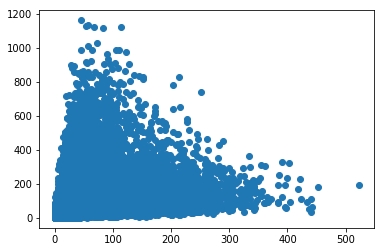

In [77]:
plt.scatter(x=df_3p_era.orb, y=df_3p_era.ast, data=df_3p_era)

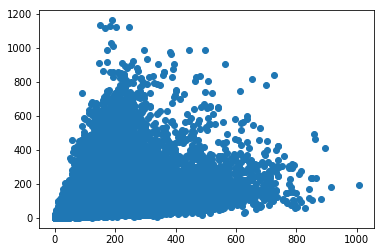

In [78]:
plt.scatter(x=df_3p_era.drb, y=df_3p_era.ast, data=df_3p_era)

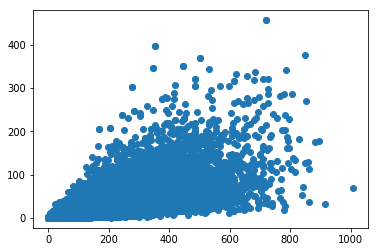

In [79]:
plt.scatter(x=df_3p_era.drb, y=df_3p_era.blk, data=df_3p_era)

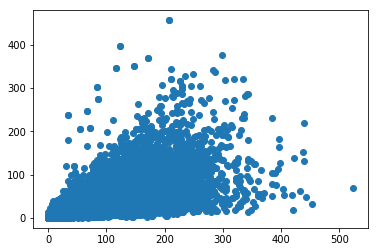

In [80]:
plt.scatter(x=df_3p_era.orb, y=df_3p_era.blk, data=df_3p_era)

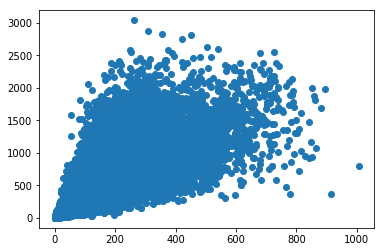

In [81]:
plt.scatter(x=df_3p_era.drb, y=df_3p_era.pts, data=df_3p_era)

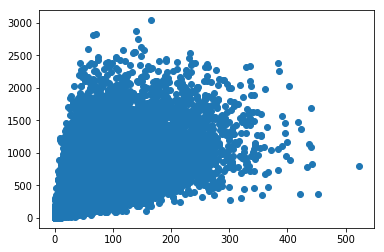

In [82]:
plt.scatter(x=df_3p_era.orb, y=df_3p_era.pts, data=df_3p_era)

# EDA on recent season

In [118]:
df_3p_era = df_3p_era[df_3p_era.tm != 'TOT']
# df_3p_era = df_3p_era.groupby(['player','season']).sum().reset_index()

In [119]:
df2019 = df_3p_era[df_3p_era.season == 2019].sort_values(by='ws',ascending=False).reset_index().drop('index',axis=1)

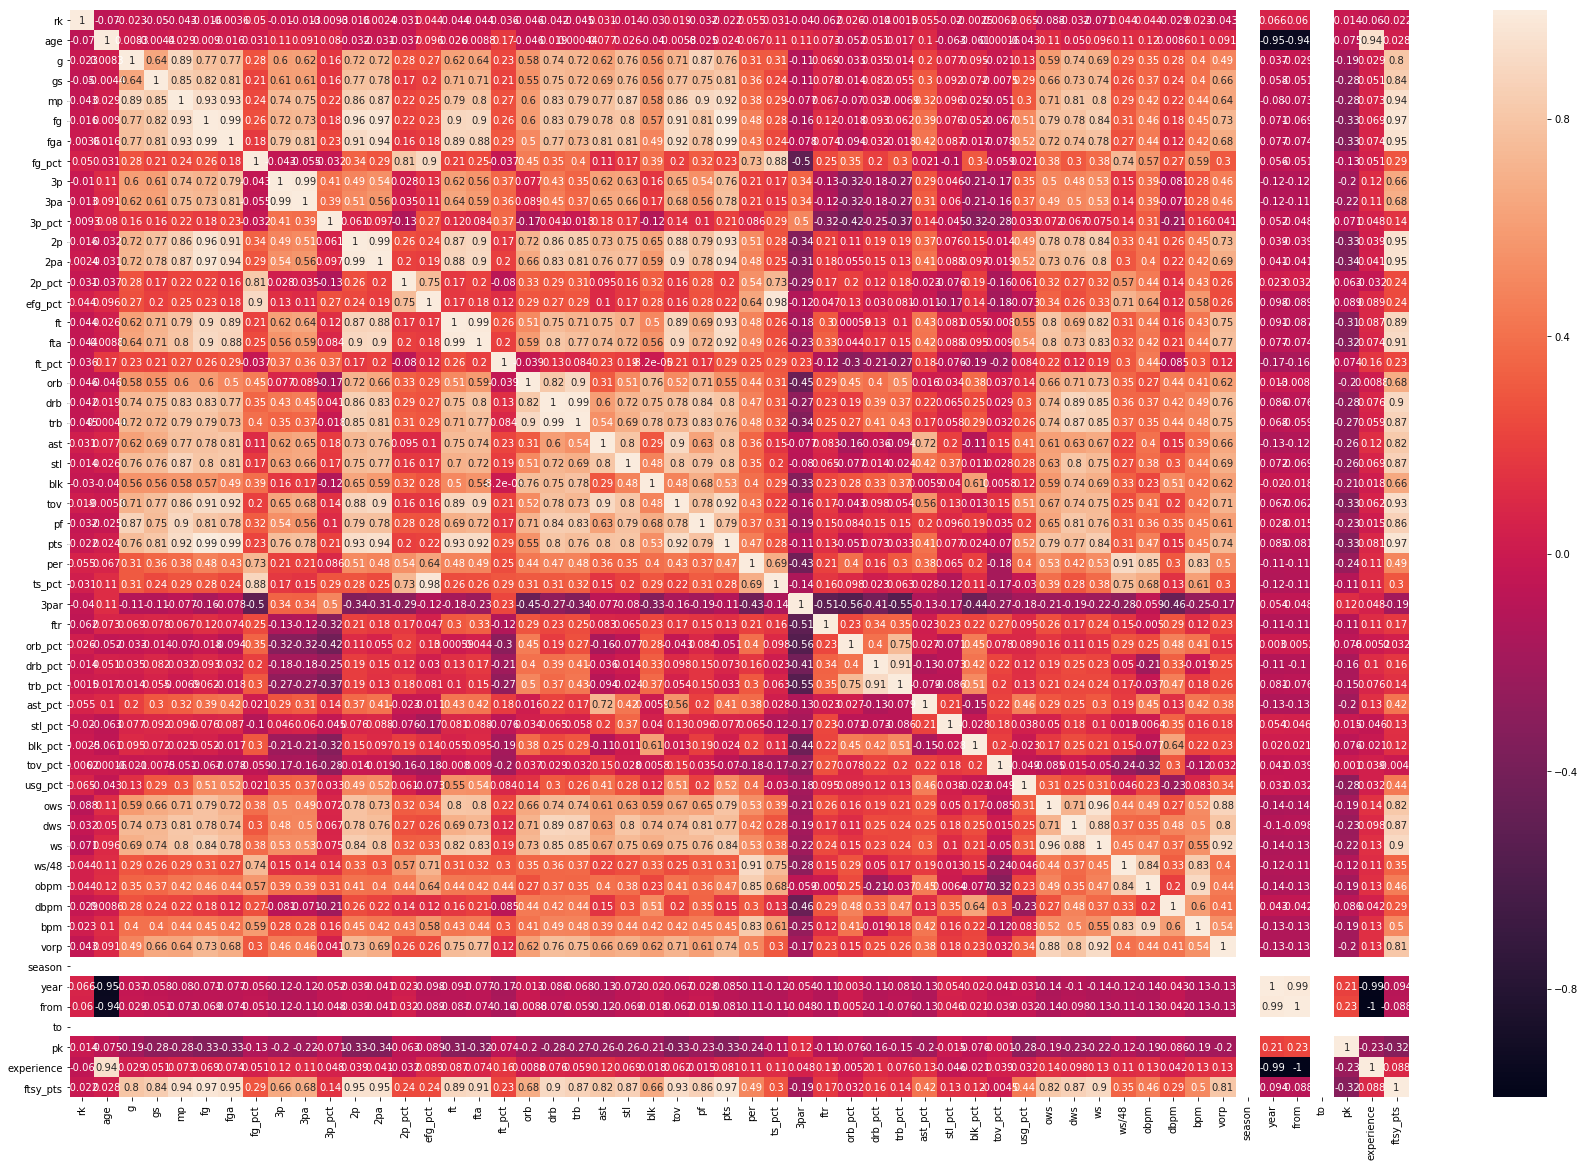

In [137]:
plt.figure(figsize=(30,20))
sns.heatmap(df2019.corr(), annot=True)
plt.show()

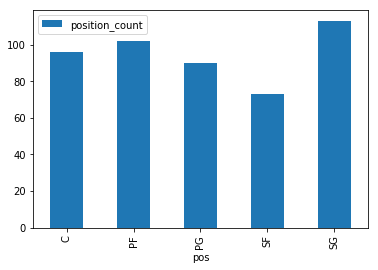

In [127]:
df2019.groupby('pos').count()[['player']].rename(columns={'player':'position_count'}).plot(kind='bar')

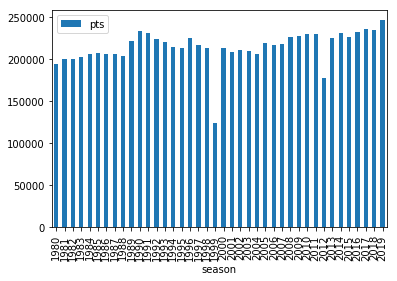

In [198]:
df_3p_era.groupby('season').sum()[['pts']].plot(kind='bar')

In [201]:
df_3p_era[df_3p_era.season == 2019].sort_values(by='ws',ascending=False)

rk                   player pos  age   tm   g    gs    mp   fg   fga  \
25897  206             James Harden  PG   29  HOU  78  78.0  2867  843  1909   
25874  187              Rudy Gobert   C   26  UTA  81  80.0  2577  476   712   
25649   18    Giannis Antetokounmpo  PF   24  MIL  72  72.0  2358  721  1247   
26031  305           Damian Lillard  PG   28  POR  80  80.0  2838  681  1533   
25870  183              Paul George  SF   28  OKC  77  77.0  2841  707  1614   
25983  269             Nikola Jokić   C   23  DEN  80  80.0  2504  616  1206   
25821  150             Kevin Durant  SF   30  GSW  78  78.0  2702  721  1383   
25742   89             Clint Capela   C   24  HOU  67  67.0  2249  474   732   
26277  480       Karl-Anthony Towns   C   23  MIN  77  77.0  2545  681  1314   
26291  492           Nikola Vučević   C   28  ORL  80  80.0  2510  701  1354   
25818  147           Andre Drummond   C   25  DET  79  79.0  2647  561  1052   
25789  124            Stephen Curry  PG   30  GSW  69  69.0  2331  632  1340   
26027  301            Kawhi Leonard  SF   27  TOR  60  60.0  2040  560  1129   
25791  126            Anthony Davis   C   25  NOP  56  56.0  1850  530  1026   
26226  446            Pascal Siakam  PF   24  TOR  80  79.0  2548  519   945   
25637    8        LaMarcus Aldridge   C   33  SAS  81  81.0  2687  684  1319   
25951  249             Kyrie Irving  PG   26  BOS  67  67.0  2214  604  1241   
25633    4             Steven Adams   C   25  OKC  80  80.0  2669  481   809   
25830  155              Joel Embiid   C   24  PHI  64  64.0  2154  580  1199   
25899  208         Montrezl Harrell   C   25  LAC  82   5.0  2158  546   888   
25860  177         Danilo Gallinari  SF   30  LAC  68  68.0  2059  409   884   
26228  448              Ben Simmons  PG   22  PHI  79  79.0  2700  540   960   
25691   54             Eric Bledsoe  PG   29  MIL  78  78.0  2272  470   971   
25773  112              Mike Conley  PG   31  MEM  70  70.0  2342  490  1120   
25891  202            Blake Griffin  PF   29  DET  75  75.0  2622  619  1341   
25844  163           Derrick Favors   C   27  UTA  76  70.0  1766  363   619   
26139  381             Jusuf Nurkić   C   24  POR  72  72.0  1974  420   826   
25677   40             Bradley Beal  SG   25  WAS  82  82.0  3028  764  1609   
26204  434         Domantas Sabonis   C   22  IND  74   5.0  1838  413   700   
25640   11            Jarrett Allen   C   20  BRK  80  80.0  2096  335   568   
25938  236               Al Horford   C   32  BOS  68  68.0  1973  387   723   
26178  410            Dwight Powell   C   27  DAL  77  22.0  1662  290   486   
26295  496             Kemba Walker  PG   28  CHO  82  82.0  2863  731  1684   
25881  194             Jerami Grant  PF   24  OKC  80  77.0  2612  409   823   
25962  258             LeBron James  SF   34  LAL  55  55.0  1937  558  1095   
26328  525           Thaddeus Young  PF   30  IND  81  81.0  2489  443   841   
25657   24            D.J. Augustin  PG   31  ORL  81  81.0  2269  318   677   
25694   57         Bojan Bogdanović  SF   29  IND  81  81.0  2573  522  1051   
25634    5              Bam Adebayo   C   21  MIA  82  28.0  1913  280   486   
25771  110          Darren Collison  PG   31  IND  76  76.0  2143  308   659   
26305  506        Russell Westbrook  PG   30  OKC  73  73.0  2630  630  1473   
26038  310              Brook Lopez   C   30  MIL  81  81.0  2322  355   786   
25752   97      Willie Cauley-Stein   C   25  SAC  81  81.0  2213  412   741   
26041  313               Kyle Lowry  PG   32  TOR  65  65.0  2213  304   739   
26161  399               Chris Paul  PG   33  HOU  58  58.0  1857  302   720   
25734   84             Jimmy Butler  SF   29  PHI  55  55.0  1824  344   747   
25711   70          Malcolm Brogdon  SG   26  MIL  64  64.0  1832  378   748   
26282  485             Myles Turner   C   22  IND  74  74.0  2119  380   780   
25804  135            DeMar DeRozan  SG   29  SAS  77  77.0  2688  631  1313   
26308  5

# Determining which metric to predict

Who will perform better for fantasy basketball?

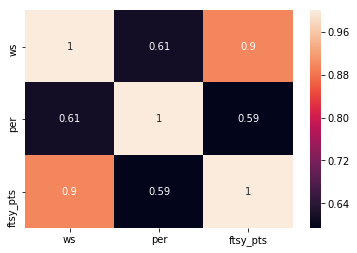

In [13]:
# There are two all-inclusive metrics that are commonly used to measure player performance
    # PER (player efficiency rating) and WS (win share)

# Checking correlation between Fantasy points and the two metrics
sns.heatmap(df_3p_era[['ws','per', 'ftsy_pts']].corr(), annot=True)

###### Win share (ws) has a much higher correlation to fantasy points (ftsy_pts) which means win share is a better predictor in who will perform better in a fantasy basketball league

Will use win share as y in modelling